### Promethee

In [1]:
import numpy as np
import pandas as pd
import random
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

#### Create random examples of flows

In [2]:
alternatives = "abcdef"
## positive flow
positive_alternatives = random.sample(list(alternatives), k = len(alternatives))
positive_alternatives = ["AUT", "ITA", "FRA", "SWE", "GER", "BEL"]
# positive_alternatives

In [3]:
## negative flow
negative_alternatives = random.sample(list(alternatives), k = len(alternatives))
negative_alternatives = ["ITA", "AUT", "FRA", "SWE", "BEL", "GER"]
# negative_alternatives

#### Find the Ranking PROMETHEE I

In [4]:
mapped = dict(zip(negative_alternatives, range(len(alternatives))))
# mapped

In [5]:
mapped_shuffled = [mapped[letter] for letter in positive_alternatives]
# mapped_shuffled

In [6]:
## We could change np.repeat to np.ones, but then in the second part of the assignment we would have to multiply the array by -1
## so it wouldn't be as clean as the code below
first = np.triu(np.repeat(1, len(alternatives))) + np.tril(np.repeat(-1, len(alternatives)))
# first

In [7]:
## We're "shuffling" the columns and rows to have the same order as the "first" matrix, if it's not clear what's happening here
## further code will explain this more in detail
second = first[:, mapped_shuffled][mapped_shuffled, :]
# second

In [8]:
one_liner = ( np.triu(np.repeat(1, len(alternatives))) + np.tril(np.repeat(-1, len(alternatives))) ) * ( np.triu(np.repeat(1, len(alternatives))) + np.tril(np.repeat(-1, len(alternatives))) )[:, [dict(zip(negative_alternatives, range(len(alternatives))))[letter] for letter in positive_alternatives ]][[dict(zip(negative_alternatives, range(len(alternatives))))[letter] for letter in positive_alternatives ], :]

In [9]:
%timeit first * second

345 ns ± 2.73 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [10]:
product = first * second
# product

In [11]:
np.all( product == one_liner )

True

In [12]:
sub = np.argwhere(product == 1)
# sub

In [13]:
sub1 = np.where(sub[:, 1] > sub[:, 0])
sub2 = sub[sub1]
# sub2

In [14]:
flow = {positive_alternatives[i]: list() for i in range(len(positive_alternatives))}
for su in sub2:
    going_from = positive_alternatives[su[0]]
    going_to = positive_alternatives[su[1]]
    flow[going_from].append(going_to)

In [15]:
flow

{'AUT': ['FRA', 'SWE', 'GER', 'BEL'],
 'ITA': ['FRA', 'SWE', 'GER', 'BEL'],
 'FRA': ['SWE', 'GER', 'BEL'],
 'SWE': ['GER', 'BEL'],
 'GER': [],
 'BEL': []}

#### Reduce the transitivity of the graph

In [16]:
import networkx as nx

In [17]:
g = nx.DiGraph(flow)
# g.edges

In [18]:
tr = nx.transitive_reduction(g)
# tr.edges

In [19]:
flow1 = {key:list() for key in flow.keys()}

In [20]:
for start, end in tr.edges:
    flow1[start].append(end)

In [21]:
flow1

{'AUT': ['FRA'],
 'ITA': ['FRA'],
 'FRA': ['SWE'],
 'SWE': ['BEL', 'GER'],
 'GER': [],
 'BEL': []}

In [22]:
flow

{'AUT': ['FRA', 'SWE', 'GER', 'BEL'],
 'ITA': ['FRA', 'SWE', 'GER', 'BEL'],
 'FRA': ['SWE', 'GER', 'BEL'],
 'SWE': ['GER', 'BEL'],
 'GER': [],
 'BEL': []}

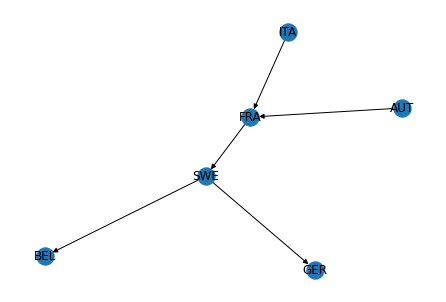

In [23]:
nx.draw(tr, with_labels=True)

## Promethee Class

#### Implementation

In [24]:

def collector1(dictionary_passed):
    def collector(func):
        dictionary_passed[func.__name__] = func
    return collector

class Promethee:
    function_types = dict()
    collecter = collector1(function_types)

    def __init__(self, criterions=None, criterion_types=None, criterion_p_qs=None, alternatives=None, alternatives_and_criterion_matrix=None, weights=None, df1=None, df2=None):
        if df1 is not None and df2 is not None:
            self.from_pandas_df(df1, df2)
        else:
            self.criterions = criterions # gain - cost
            self.criterion_types = criterion_types # type1 through 6
            self.criterion_functions = [self.function_types[type_of_function](self, gain_cost) for type_of_function, gain_cost in zip(self.criterion_types, self.criterions)]
            self.criterion_p_qs = criterion_p_qs # if no p and q needed give an empty list in its place
            self.alternatives = alternatives # Names
            self.alternatives_and_criterion_matrix = alternatives_and_criterion_matrix # self explenatory
            self.weights = weights # self explenatory
            

    def pandas_helper(self, values):
        values_new = []
        if values[0] >= 0:
            values_new.append(values[0])
        if values[1] >= 0:
            values_new.append(values[1])
        return values_new

    def from_pandas_df(self, df_alternatives, df_p_q):
        ## Same idea as in the __init__
        
        ## In this implementation I assume that the order in df_alternatives.columns is the same as the order of df_p_q.index (rows)
        ## Here it is not a problem because data was created with this assumption but if the order would be different then it would lead to a bug
        ## Therefore I'm supplying the code to fix it here:

        ## df_p_q = df_p_q.set_index("Criteria").loc[df_alternatives.columns[1:], :]

        ## This code will work only if the "name" column is first in df_alternatives, so there's a real bug-fixer
        
        df_p_q = df_p_q.set_index("Criteria").loc[df_alternatives.columns[~df_alternatives.columns.isin(["Name"])], :]

        self.criterions = df_p_q["type"].tolist()
        self.criterion_types = df_p_q["type-number"].tolist()
        self.criterion_functions = [self.function_types[type_of_function](self, gain_cost) for type_of_function, gain_cost in zip(self.criterion_types, self.criterions)]
        self.criterion_p_qs = list(map(self.pandas_helper, df_p_q.loc[:, ["p", "q"]].to_numpy()))
        self.alternatives = df_alternatives.to_numpy()[:, 0]
        self.alternatives_and_criterion_matrix = df_alternatives.to_numpy()[:, 1:]
        self.weights = df_p_q["weights"].to_numpy()


    def _marginal_preference_indices(self, criterion_function, criterion_p_q, column):
        number_of_alternatives = len(self.alternatives_and_criterion_matrix)
        new_matrix = np.zeros((number_of_alternatives, number_of_alternatives))

        for i in range(number_of_alternatives):
            for j in range(number_of_alternatives):
                if i == j:
                    continue
                a = self.alternatives_and_criterion_matrix[i][column]
                b = self.alternatives_and_criterion_matrix[j][column]
                new_matrix[i, j] = criterion_function(a, b, *criterion_p_q)

        
        return new_matrix[np.newaxis, ...]
    
    def _every_marginal_preference_indicies(self):
        general_matrix = None
        
        for i, cr_function, cr_p_q in zip(range(len(self.criterion_p_qs)), self.criterion_functions, self.criterion_p_qs):
            n_matrix = self._marginal_preference_indices(cr_function, cr_p_q, i)

            if i == 0:
                general_matrix = n_matrix
            else:
                general_matrix = np.concatenate((general_matrix, n_matrix))
            
            
        return general_matrix
    
    def comprehensive_preference_index(self):
        matrices = self._every_marginal_preference_indicies()

        ## Loop example
        # cpi = np.zeros(matrices.shape[1:])
        # for i, matrix in enumerate(matrices):
        #     cpi += self.weights[i] * matrix
        # cpi /= sum(self.weights)

        cpi1 = (np.array(self.weights).reshape(len(self.criterions),1,1) * matrices).sum(axis=0)
        cpi1 /= sum(self.weights)
        
        return cpi1
    
    def get_positive_and_negative_flow(self):
        cpi = self.comprehensive_preference_index()
        positive = list(zip(self.alternatives, np.sum(cpi, 1)))
        negative = list(zip(self.alternatives, np.sum(cpi, 0)))
        complete = list(zip(self.alternatives, np.sum(cpi, 1) - np.sum(cpi, 0)))
        positive.sort(key = lambda x: x[1], reverse=True)
        negative.sort(key = lambda x: x[1])
        complete.sort(key = lambda x: x[1], reverse=True)
        return np.array(positive)[:, 0], np.array(negative)[:, 0], np.array(complete)[:, 0]
                

    def get_the_promethee_1_flow(self):
        # if hasattr(self, "promethee_I_flow"):
        #     return self.promethee_I_flow

        alternatives = self.alternatives
        positive_alternatives, negative_alternatives, _ = self.get_positive_and_negative_flow()
        ## It actually can be done in one line (Promethee I flow, provided that we already have pos/neg flows),
        ## although it looks a bit messy therefore I also processed the results for convenience
        ## Rows and columns follow the "positive_alternatives" order
        ## Ones on upper triangular represent that the alternative in row i is better than the alternative in column j
        ## Minus ones(still on upper triangular) represent that there is an incomparability between the alternative in row i and alternative in column j
        ## Zeros on diagonal simply mean that the alternatives are the same 
        one_liner = ( np.triu(np.repeat(1, len(alternatives))) + np.tril(np.repeat(-1, len(alternatives))) ) * ( np.triu(np.repeat(1, len(alternatives))) + np.tril(np.repeat(-1, len(alternatives))) )[:, [dict(zip(negative_alternatives, range(len(alternatives))))[letter] for letter in positive_alternatives ]][[dict(zip(negative_alternatives, range(len(alternatives))))[letter] for letter in positive_alternatives ], :]
        
        ## But the whole matrix(not just the upper triangular) represents consistency i.e. if some alternative i is better/worse than the alternative j on
        ## both the positive flow and negative flow the entry in matrix[i,j] = 1 and matrix[j,i] = 1, but when some alternative isn't better/worse on both the flows
        ## then it introduces inconsistency and results in matrix[i,j] = -1 and matrix[j,i] = -1

        ## simple example
        """
        positive_flow = A -> B -> C
        negative_flow = B -> A -> C

        Note that the rows and columns follow the positive_flow hierarchy i.e. Row0, Col0 = A ; Row1, Col1 = B etc.
        positive_flow_matrix = [[0, 1, 1]
                                [-1, 0, 1]
                                [-1, -1, 0]]
        
        negative_flow_matrix = [[0, -1, 1]
                                [1, 0, 1]
                                [-1, -1, 0]]
        
        ## "consistency matrix"
        pair_wise_mul_result = [[0, -1, 1]
                                [-1, 0, 1]
                                [1, 1, 0]]
        
        Note that if positive_flow = negative_flow then:
        pair_wise_mul_result = [[0, 1, 1]
                                [1, 0, 1]
                                [1, 1, 0]]
        which gives as the positive/negative flow order itself
        """

        product = one_liner
        
        sub = np.argwhere(product == 1)

        sub1 = np.where(sub[:, 1] > sub[:, 0])
        sub2 = sub[sub1]

        flow = {positive_alternatives[i]: list() for i in range(len(positive_alternatives))}
        for su in sub2:
            going_from = positive_alternatives[su[0]]
            going_to = positive_alternatives[su[1]]
            flow[going_from].append(going_to)

        g = nx.DiGraph(flow)
        tr = nx.transitive_reduction(g)
        

        flow1 = {key:list() for key in flow.keys()}

        for start, end in tr.edges:
            flow1[start].append(end)
        if not hasattr(self, "promethee_I_flow"):
            self.promethee_I_flow = flow1
            
        return flow1
    
    def visualize_graph(self):
        graph = nx.DiGraph(self.get_the_promethee_1_flow())
        
        # plt.title('draw_networkx')
        plt.figure(figsize=(15, 15))
        pos=graphviz_layout(graph, prog='dot')
        nx.draw(graph, pos, with_labels=True, arrows=True)
        return graph
    
    def changes(self, flows: list):
        dicts = []
        for flow in flows:
            dicts.append(dict())
            for i in range(len(flow) - 1):
                dicts[-1][flow[i]] = [flow[i+1]]
            dicts[-1][flow[-1]] = []
        return dicts
    

    def visualize_graph_complete(self):
        positive, negative, promethee_2 = self.get_positive_and_negative_flow()
        graphs = self.changes([positive, negative, promethee_2])
        
        titles = ["positive", "negative", "Promethee 2"]
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,14))
        for i, graph in enumerate(graphs):

            graph = nx.DiGraph(graph)
            pos=graphviz_layout(graph, prog='dot')
            nx.draw_networkx(graph, pos, with_labels=True, arrows=True, ax=ax[i])
            ax[i].set_title(titles[i], color="r")
        
        plt.show()
        return graphs
        
    @collecter
    def type1(self, which_one):
        assert which_one in ("gain", "cost")
        def type1return(a, b):
            support = -1
            if which_one == "gain":
                pass
            elif which_one == "cost":
                a,b = b, a
            

            if a-b > 0:
                support = 1
            else:
                support = 0
          
            return support

        return type1return

    @collecter
    def type2(self, which_one):
        assert which_one in ("gain", "cost")
        def type2return(a, b, q):
            support = -1
            if which_one == "gain":
                pass
            elif which_one == "cost":
                a, b = b, a
            

            if a - b > q:
                support = 1
            else:
                support = 0
            
            return support

        return type2return

    @collecter
    def type3(self, which_one):
        assert which_one in ("gain", "cost")
        def type3return(a, b, p):
            support = -1
            if which_one == "gain":
                pass
            elif which_one == "cost":
                a, b = b, a
            

            if a - b > p:
                support = 1
            elif a - b <= 0:
                support = 0
            else:
                support = (a-b) / p
            
            return support
        return type3return
    
    @collecter
    def type4(self, which_one):
        assert which_one in ("gain", "cost")
        def type4return(a, b, p, q):
            support = -1
            if which_one == "gain":
                pass
            elif which_one == "cost":
                a, b = b, a
            

            if a - b > p:
                support = 1
            elif a - b <= q:
                support = 0
            else:
                support = 0.5

            return support
        return type4return
            
    @collecter
    def type5(self, which_one):
        assert which_one in ("gain", "cost")
        def type5return(a, b, p, q):
            support = -1
            if which_one == "gain":
                pass
            elif which_one == "cost":
                a, b = b, a
            

            if a - b > p:
                support = 1
            elif a - b <= q:
                support = 0
            else:
                support = (a-b-q) / (p - q)
            
            return support
        return type5return
    
    
    def type6(self, which_one):
        ## "Let It Be" undone
        pass
            
            

### Example from the lectures

In [25]:
al_cri_matrix = [[98, 8, 400],
                [58, 0, 800],
                [66, 5, 1000],
                [74, 3, 600],
                [80, 7, 200],
                [82, 10, 600]

]
alternatives = ["ITA", "BEL", "GER", "SWE", "AUT", "FRA"]

In [26]:
pro = Promethee(["gain", "gain", "cost"], ["type1", "type3", "type5"], [[], [2], [300, 100]], ["ITA", "BEL", "GER", "SWE", "AUT", "FRA"], al_cri_matrix, [3, 2, 5])

In [27]:
pro.comprehensive_preference_index()

array([[0.  , 1.  , 1.  , 0.75, 0.4 , 0.55],
       [0.  , 0.  , 0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.2 , 0.  , 0.  ],
       [0.  , 0.75, 0.8 , 0.  , 0.  , 0.  ],
       [0.25, 1.  , 1.  , 1.  , 0.  , 0.5 ],
       [0.2 , 0.75, 1.  , 0.5 , 0.5 , 0.  ]])

In [28]:
# pro.get_positive_and_negative_flow()

In [29]:
pro.get_the_promethee_1_flow()

{'AUT': ['FRA'],
 'ITA': ['FRA'],
 'FRA': ['SWE'],
 'SWE': ['BEL', 'GER'],
 'GER': [],
 'BEL': []}

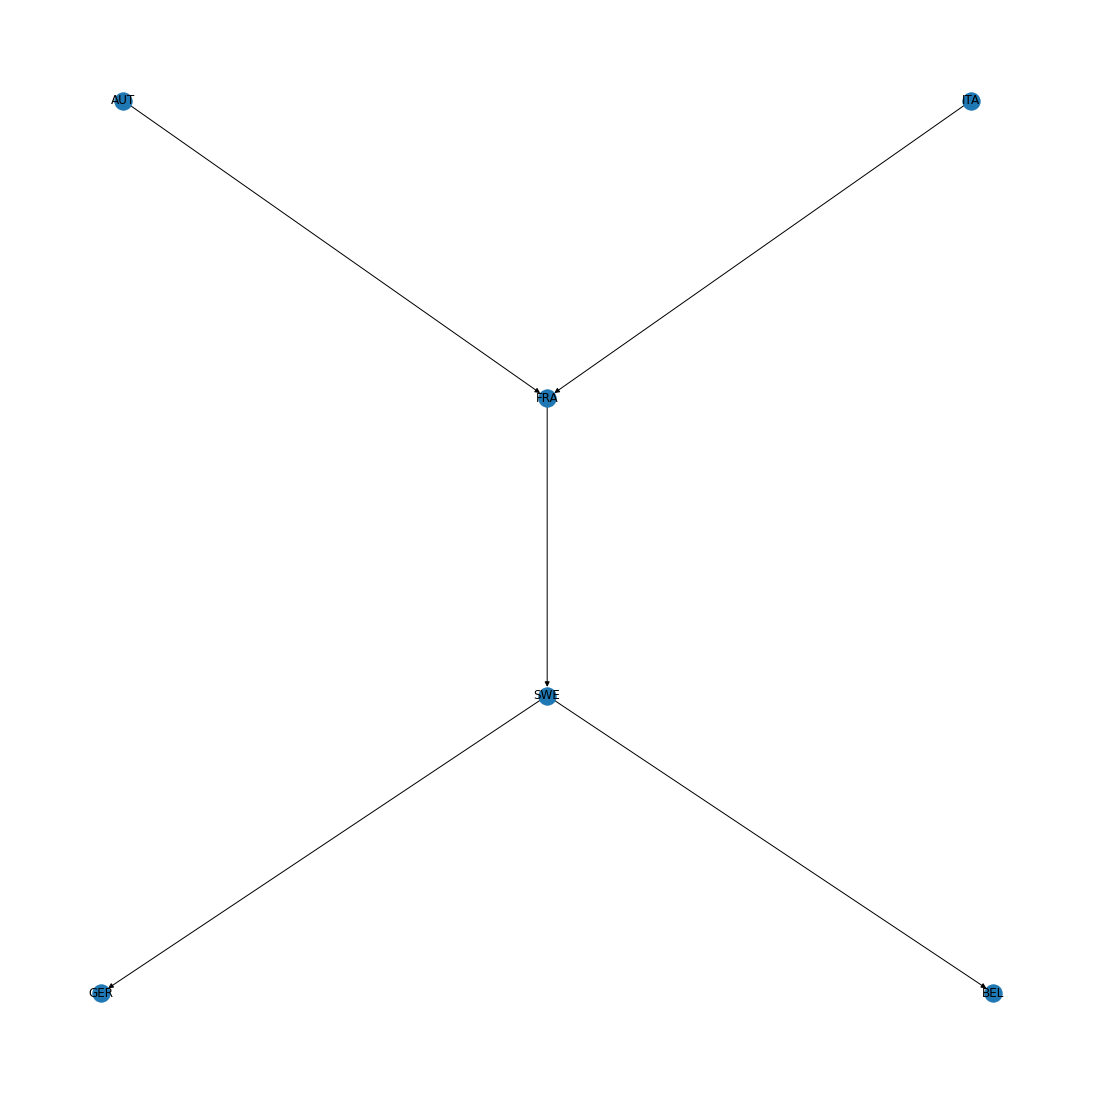

In [30]:
pro.visualize_graph()

### My example -version 1

In [31]:
alternatives = pd.read_csv("data/Alternatives.csv", sep=";")
alternatives.head()

,Name,Price,Difficulty,Playthrough time,Graphics,Lore,Soundtrack,Gameplay,Bugs
0,Demon's souls,50,7,40,6,9,7,8,3
1,Dark Souls I,60,8,40,8,10,9,7,3
2,Dark Souls II,70,6,50,7,7,8,6,6
3,Dark Souls III,150,9,60,9,9,10,9,2
4,Dark Souls III: Ashes of Ariandel,50,10,15,9,10,10,9,2


In [32]:
p_q = pd.read_csv("data/p_and_q.csv", sep=";")
p_q.head()

,Criteria,q,p,type-number,type,weights
0,Price,20.0,50.0,type5,cost,5
1,Difficulty,2.0,4.0,type4,gain,6
2,Playthrough time,15.0,25.0,type5,gain,3
3,Graphics,1.0,3.0,type4,gain,4
4,Lore,0.0,2.0,type4,gain,9


In [33]:
new_pro = Promethee(df1=alternatives, df2=p_q)

In [34]:
new_pro.comprehensive_preference_index()

array([[0.        , 0.        , 0.26470588, 0.09803922, 0.05882353,
        0.        , 0.06535948, 0.09803922, 0.09803922, 0.47058824,
        0.38235294, 0.        , 0.08823529, 0.12091503, 0.15686275,
        0.24509804, 0.15686275],
       [0.32352941, 0.        , 0.45098039, 0.18627451, 0.05882353,
        0.        , 0.03267974, 0.38235294, 0.18627451, 0.4379085 ,
        0.47058824, 0.19607843, 0.28431373, 0.28431373, 0.24509804,
        0.47058824, 0.18300654],
       [0.19607843, 0.        , 0.        , 0.09803922, 0.05882353,
        0.05882353, 0.        , 0.09803922, 0.09803922, 0.31699346,
        0.29411765, 0.19607843, 0.        , 0.        , 0.        ,
        0.19607843, 0.09150327],
       [0.26470588, 0.32352941, 0.55882353, 0.        , 0.05882353,
        0.05882353, 0.        , 0.22875817, 0.29411765, 0.50980392,
        0.28431373, 0.38235294, 0.34313725, 0.31372549, 0.45098039,
        0.56862745, 0.31372549],
       [0.38235294, 0.29411765, 0.64705882, 0.186274

In [35]:
new_pro.get_positive_and_negative_flow()

(array(['Bloodborne', 'Dark Souls III: Ashes of Ariandel',
        'Dark Souls III: The Ringed City', 'Witcher 3', 'Dark Souls III',
        'Dishonored', 'Dark Souls I', 'Sekiro: Shadows Die Twice',
        'Elden Ring', 'Dishonored 2', 'Witcher', 'God of War',
        "Demon's souls", 'Dark Souls II', 'Nioh 2', 'Nioh', 'Witcher 2'],
       dtype='<U33'),
 array(['Dark Souls III: The Ringed City', 'Bloodborne',
        'Dark Souls III: Ashes of Ariandel', 'Dark Souls III',
        'Dark Souls I', 'Dishonored', 'Dishonored 2', 'Elden Ring',
        'Witcher 3', 'Sekiro: Shadows Die Twice', 'God of War',
        "Demon's souls", 'Witcher', 'Dark Souls II', 'Nioh 2', 'Witcher 2',
        'Nioh'], dtype='<U33'),
 array(['Bloodborne', 'Dark Souls III: The Ringed City',
        'Dark Souls III: Ashes of Ariandel', 'Dark Souls III',
        'Dark Souls I', 'Witcher 3', 'Dishonored', 'Elden Ring',
        'Dishonored 2', 'Sekiro: Shadows Die Twice', 'God of War',
        'Witcher', "Demon's s

In [36]:
new_pro.get_the_promethee_1_flow()

{'Bloodborne': ['Dark Souls III: Ashes of Ariandel'],
 'Dark Souls III: Ashes of Ariandel': ['Witcher 3', 'Dark Souls III'],
 'Dark Souls III: The Ringed City': ['Witcher 3', 'Dark Souls III'],
 'Witcher 3': ['Sekiro: Shadows Die Twice'],
 'Dark Souls III': ['Dishonored', 'Dark Souls I'],
 'Dishonored': ['Dishonored 2', 'Elden Ring', 'Sekiro: Shadows Die Twice'],
 'Dark Souls I': ['Dishonored 2', 'Elden Ring', 'Sekiro: Shadows Die Twice'],
 'Sekiro: Shadows Die Twice': ['Witcher', 'God of War'],
 'Elden Ring': ['Witcher', 'God of War'],
 'Dishonored 2': ['Witcher', 'God of War'],
 'Witcher': ['Dark Souls II'],
 'God of War': ["Demon's souls"],
 "Demon's souls": ['Dark Souls II'],
 'Dark Souls II': ['Nioh 2'],
 'Nioh 2': ['Witcher 2', 'Nioh'],
 'Nioh': [],
 'Witcher 2': []}

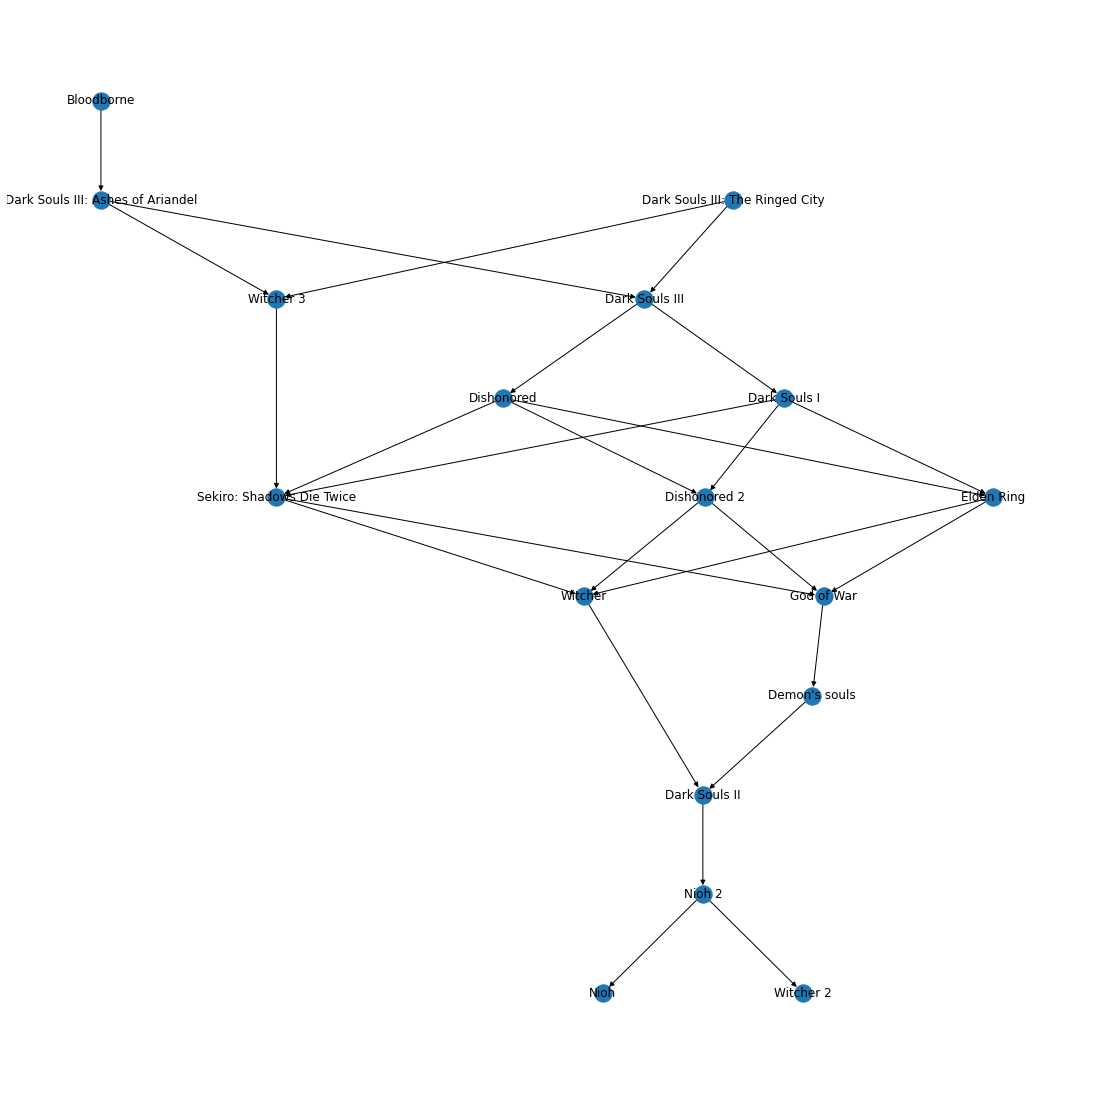

In [37]:
g1 = new_pro.visualize_graph()

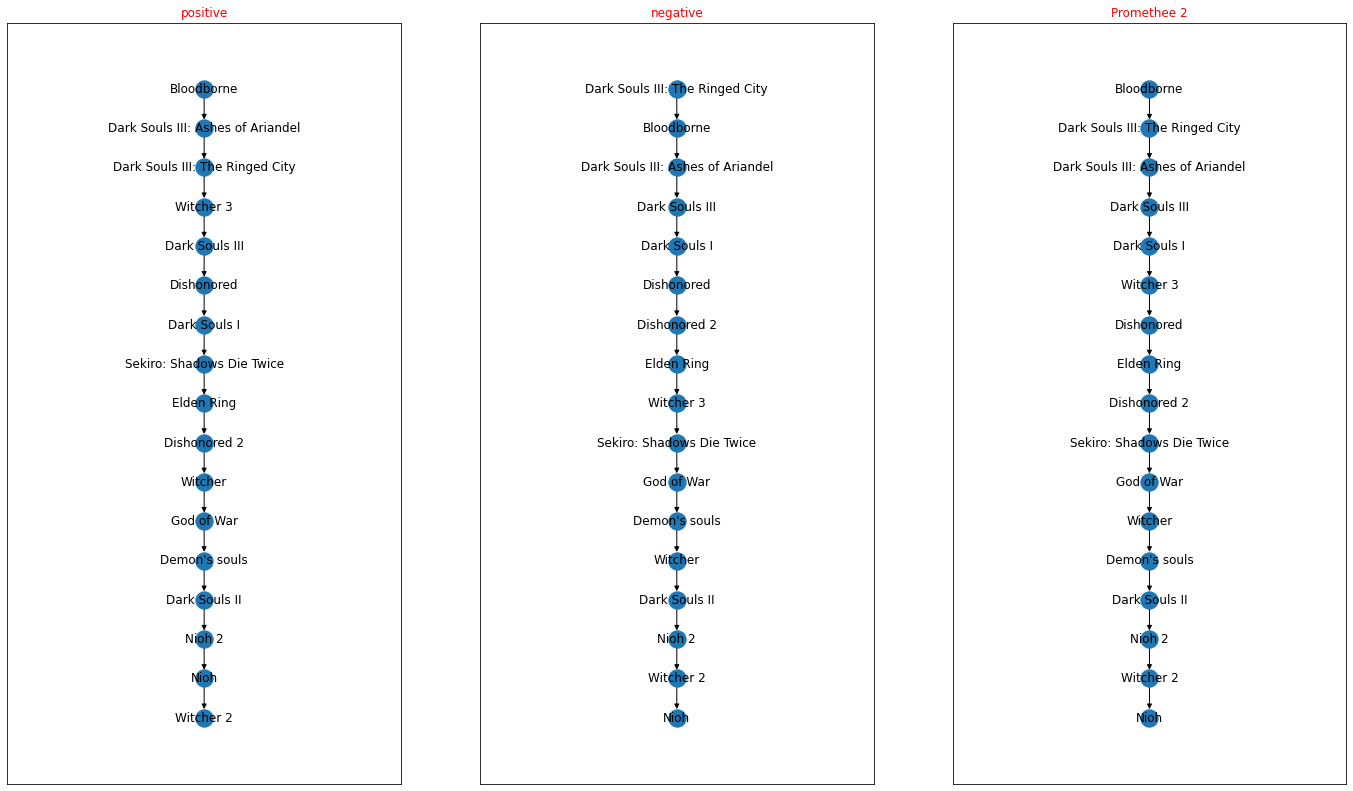

In [38]:
gr = new_pro.visualize_graph_complete()

### My Example -version 2

Here I added some random noise to alternatives after scaling them from 0-10 to 0-100. It might be considered as a change of evaluation based on different scale.
Obviously when you have 11 options and 101 and you go from former to latter it will inevitably cause some minor changes.

In [39]:
corrected_alternatives = pd.read_csv("data/Alternatives_correction.csv")
corrected_alternatives.head()

,Name,Price,Difficulty,Playthrough time,Graphics,Lore,Soundtrack,Gameplay,Bugs
0,Demon's souls,50,71,40,58,92,69,81,34
1,Dark Souls I,60,77,40,81,100,89,68,32
2,Dark Souls II,70,62,50,67,70,79,56,62
3,Dark Souls III,150,90,60,86,89,95,94,20
4,Dark Souls III: Ashes of Ariandel,50,100,15,85,100,97,91,18


In [40]:
corrected_p_q = pd.read_csv("data/p_q_correction.csv")
corrected_p_q.head()

,Criteria,q,p,type-number,type,weights
0,Price,20.0,50.0,type5,cost,5
1,Difficulty,20.0,40.0,type4,gain,6
2,Playthrough time,15.0,25.0,type5,gain,3
3,Graphics,10.0,30.0,type4,gain,4
4,Lore,0.0,20.0,type4,gain,9


In [41]:
pro2 = Promethee(df1 = corrected_alternatives, df2 = corrected_p_q)

In [42]:
%%timeit
pro2.get_the_promethee_1_flow()

3.48 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


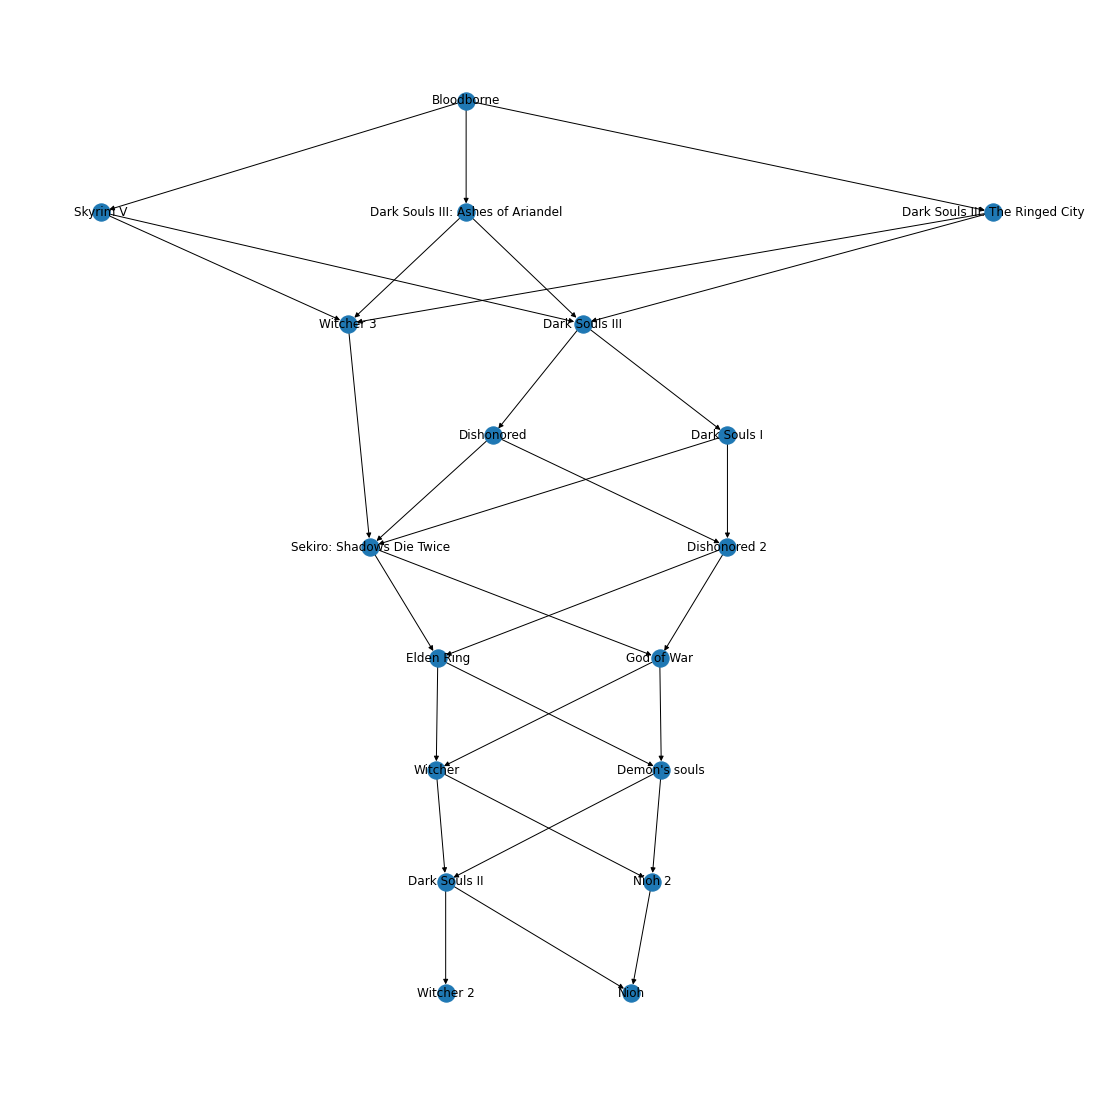

In [43]:
g2 = pro2.visualize_graph()

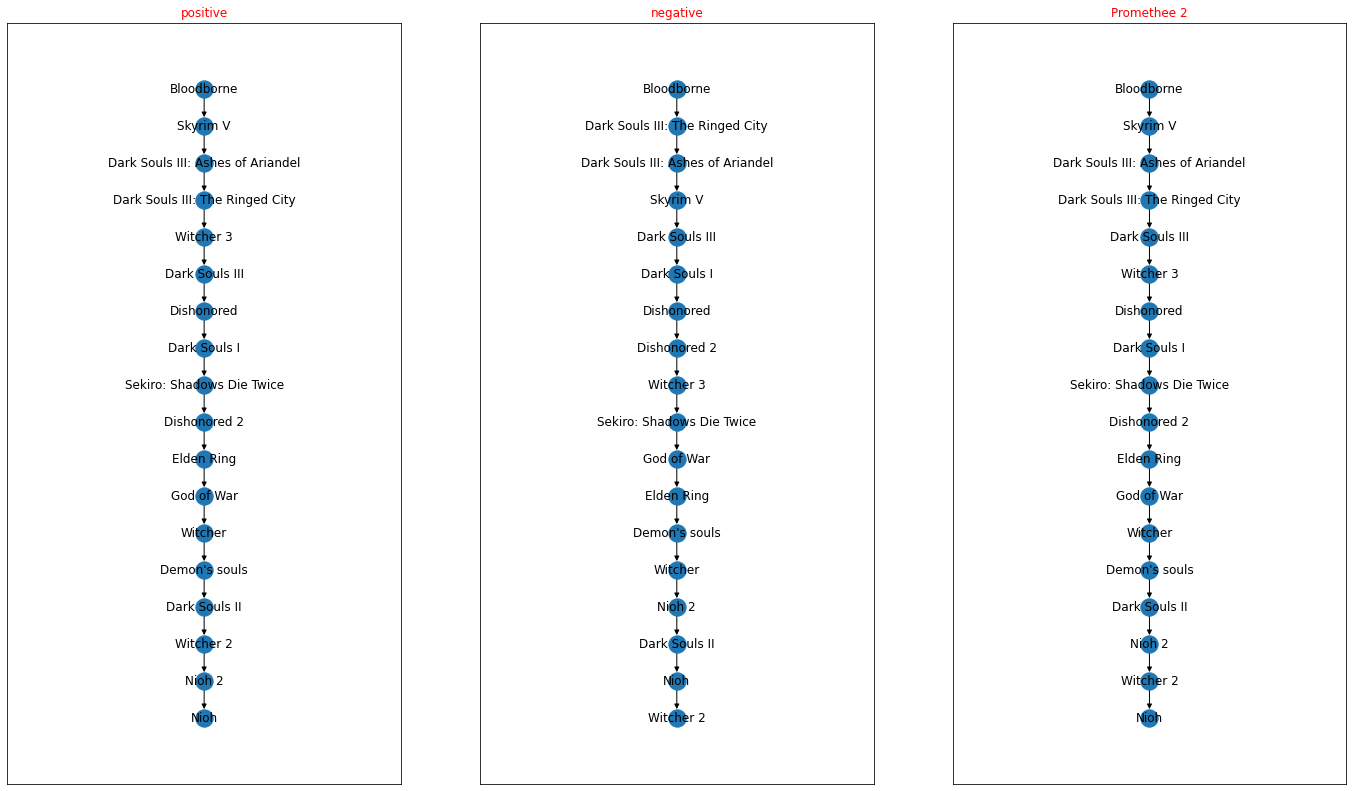

In [44]:
g2 = pro2.visualize_graph_complete()